In [13]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as gg
import umap

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline

from utils.data_utils import load_data

## Set Parameters

In [2]:
alphas = [1, 5, 10]
l1_ratios = [0.8, 1]

## Load Data

In [3]:
x_train_df, y_train_df, meta_train_df, x_test_df, y_test_df, meta_test_df = load_data(
    y_col="Metadata_CellLine", wt_col="WT", return_meta=True, shuffle_row_order=True
)
print(x_train_df.shape)
print(x_test_df.shape)

x_test_df.head(3)

(25716, 1283)
(4560, 1283)


,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MeanRadius,Cells_AreaShape_MinFeretDiameter,...,Nuclei_Texture_SumEntropy_RNA_10_02,Nuclei_Texture_SumEntropy_RNA_10_03,Nuclei_Texture_SumEntropy_RNA_20_00,Nuclei_Texture_SumEntropy_RNA_20_01,Nuclei_Texture_SumEntropy_RNA_20_02,Nuclei_Texture_SumEntropy_RNA_20_03,Nuclei_Texture_SumEntropy_RNA_5_00,Nuclei_Texture_SumEntropy_RNA_5_01,Nuclei_Texture_SumEntropy_RNA_5_02,Nuclei_Texture_SumEntropy_RNA_5_03
0,1.182477,-1.553551,1.737635,1.246981,-1.191446,-1.922448,2.711672,2.393350,-0.378423,0.962253,...,0.953201,0.880004,-1.810348,-1.641279,-1.824765,-1.688172,0.894541,0.953872,0.877478,0.913655
1,-0.070671,1.582739,-0.913048,0.049144,0.297508,0.332347,-0.175932,-0.041567,0.421634,-0.134632,...,1.560862,2.351783,1.443972,-1.732957,1.086626,0.033441,2.311240,1.859942,2.272056,2.331073
2,1.620392,-0.497091,-1.370472,-0.356009,0.347040,-0.577204,1.038133,0.723820,0.673345,1.935821,...,2.028826,2.032238,1.095470,0.890064,1.521495,1.625416,2.008528,1.883526,2.035588,2.105522
3,0.396886,0.650658,0.715551,-1.505780,-1.887713,-0.931207,0.180392,0.681441,0.310800,1.300368,...,-0.372619,-0.396865,0.232729,0.356866,0.054314,-0.531580,-0.281956,-0.156941,-0.475477,-0.255428
4,-0.192020,-0.945724,-0.214378,1.276509,-1.764681,-0.549392,0.796170,0.896952,-0.483122,-0.528420,...,2.376516,1.330701,0.595993,1.279859,1.522405,0.795610,2.216940,2.441234,2.393652,2.029251


In [11]:
# Apply UMAP
reducer = umap.UMAP(random_state=123)
embedding = reducer.fit_transform(x_train_df)

# Setup plotting logic
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df = embedding_df.merge(meta_train_df, left_index=True, right_index=True)

/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/rp_tree.py:439: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$46call_function.15', defined at /Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/rp_tree.py (446)

File "../../../../../../../miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/rp_tree.py", line 446:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
     

In [15]:
embedding_df.head()

,x,y,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_CellLine,Metadata_Dosage
0,3.795457,-6.274085,682926202460102822083340368073528737,54,207106_exposure320,C10,PlateMap_207106_exposure320,CloneE,0.7
1,-8.940310,1.962281,149190356589526962575527614300837924345,43,207106_exposure320,B08,PlateMap_207106_exposure320,CloneE,0.0
2,-6.435139,0.511571,312850940689131410215311730827354255410,115,207106_exposure320,B08,PlateMap_207106_exposure320,CloneE,0.0
3,-8.619833,-0.490114,186624241918566294700069146130097675422,147,207106_exposure320,B04,PlateMap_207106_exposure320,WT,0.0
4,-3.925464,2.860532,220543780975090216871257395408385872537,255,207106_exposure320,B04,PlateMap_207106_exposure320,WT,0.0


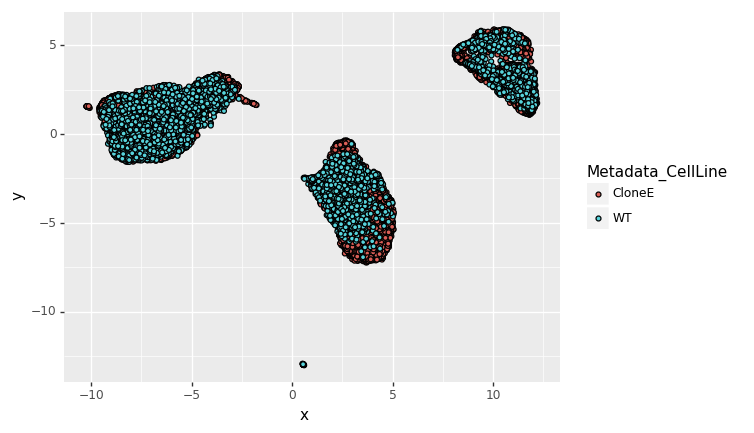

<ggplot: (310985024)>

In [21]:
gg.ggplot(embedding_df, gg.aes(x="x", y="y")) + gg.geom_point(gg.aes(fill="Metadata_CellLine"))

In [6]:
y_train_df.head(10)

,Metadata_CellLine,status
0,CloneE,1
1,CloneE,1
2,CloneE,1
3,WT,0
4,WT,0
5,CloneE,1
6,CloneE,1
7,WT,0
8,CloneE,1
9,CloneE,1


## Optimize

In [7]:
clf_parameters = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': alphas,
    'classify__l1_ratio': l1_ratios
}

estimator = Pipeline(
    steps=[(
        'classify',
        SGDClassifier(
            random_state=0,
            class_weight='balanced',
            loss='log',
            max_iter=50,
            tol=1e-3
        )
    )]
)

cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
)
cv_pipeline.fit(X=x_train_df, y=y_train_df.status.tolist())

GridSearchCV(cache_cv=True, cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [1, 5, 10], 'classify__l1_ratio': [0.8, 1]},
       refit=True, return_train_score=True, scheduler=None,
       scoring='roc_auc')

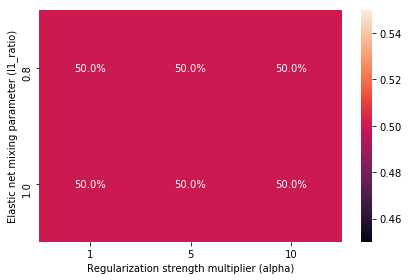

In [8]:
cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()

In [9]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,...,mean_train_score,std_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,6.600070,0.752595,0.031541,0.024328,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,1,0.8,log,elasticnet,1,0.8,log,elasticnet
1,4.630629,1.258691,0.031176,0.023312,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,1,1,log,elasticnet,1,1.0,log,elasticnet
2,3.567247,0.728652,0.017266,0.009310,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,5,0.8,log,elasticnet,5,0.8,log,elasticnet
3,3.427735,0.652641,0.016790,0.006459,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,5,1,log,elasticnet,5,1.0,log,elasticnet
4,3.034781,0.343511,0.021343,0.008993,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,10,0.8,log,elasticnet,10,0.8,log,elasticnet
5,2.867339,0.180369,0.024736,0.020789,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.0,10,1,log,elasticnet,10,1.0,log,elasticnet
